In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel


# Obtención de datos

Available fields are: bgs_target, chi2, cmx_target, coadd_fiberstatus, coadd_numexp, coadd_numnight, coadd_numtile, coeff, data_release, datasetgroup, dateobs, dateobs_center, dec, deltachi2, desi_target, desiname, exptime, extra_files, fa_target, fa_type, file, flux, healpix, instrument, ivar, main_nspec, main_primary, mask, mean_delta_x, mean_delta_y, mean_fiber_dec, mean_fiber_ra, mean_mjd, mean_psf_to_fiber_specflux, model, mws_target, ncoeff, npixels, numobs_init, objtype, obsconditions, plate_dec, plate_ra, pmdec, pmra, priority_init, program, ra, redshift, redshift_err, redshift_warning, ref_epoch, rms_delta_x, rms_delta_y, scnd_target, site, sparcl_id, specid, specprimary, spectype, spgrpval, std_fiber_dec, std_fiber_ra, subpriority, subtype, survey, sv1_bgs_target, sv1_desi_target, sv1_mws_target, sv1_scnd_target, sv2_bgs_target, sv2_desi_target, sv2_mws_target, sv2_scnd_target, sv3_bgs_target, sv3_desi_target, sv3_mws_target, sv3_scnd_target, sv_nspec, sv_primary, targetid, telescope, tsnr2_bgs, tsnr2_elg, tsnr2_gpbbackup, tsnr2_gpbbright, tsnr2_gpbdark, tsnr2_lrg, tsnr2_lya, tsnr2_qso, updated, wave_sigma, wavelength, wavemax, wavemin, zcat_nspec.


In [41]:
from sparcl.client import SparclClient

table = Table.read('fuji/zpix-sv3-bright.fits')
mask = table['SPECTYPE'] == 'STAR'

targetid = table[mask]['TARGETID']
x = list(targetid)
x = [ int(y) for y in x ]
table.columns
client = SparclClient()

def getdata(a, b):
    inc = ['targetid', 'flux', 'wavelength', 'redshift', 'subtype']
    res = client.retrieve_by_specid(specid_list = x[a:b], include = inc, dataset_list = ['DESI-DR1'])
    return res.data


In [ ]:
d = getdata(0, 10_000)
d

In [33]:
table['SUBTYPE'][0]

masked

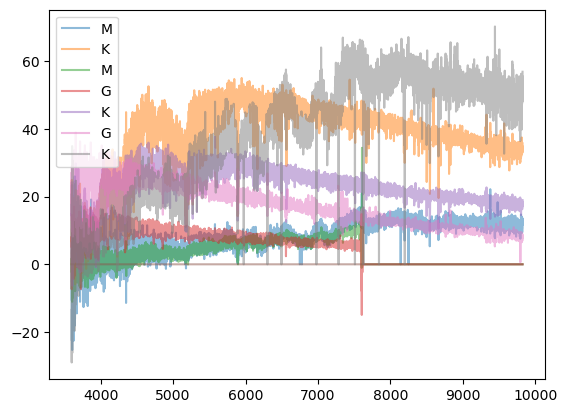

In [55]:
for i in range(1, 9):
    plt.plot(d[i]['wavelength'], d[i]['flux'], label=d[i]['subtype'], alpha=0.5)
plt.legend()

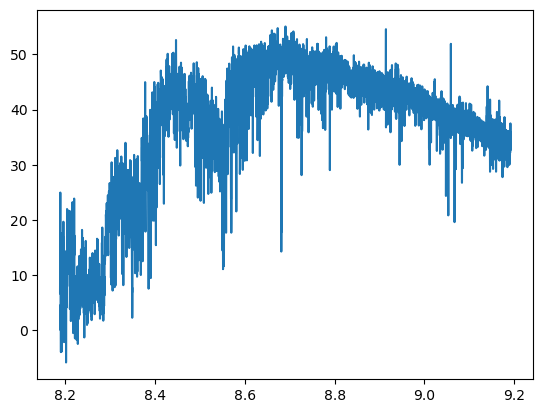

In [60]:
plt.plot(np.log(d[2]['wavelength']), d[2]['flux'])

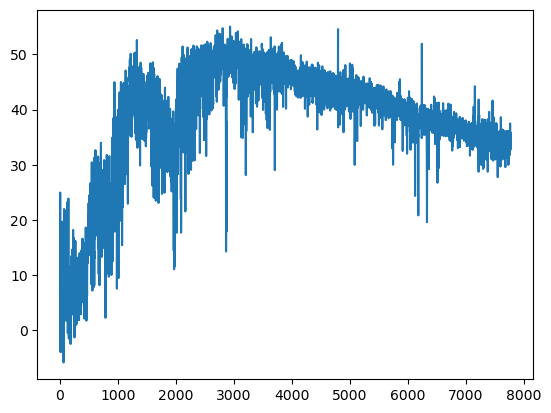

# Machine Learning

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from scipy.interpolate import interp1d

In [64]:
N_POINTS = 5000
WAVELENGTH_MIN = 3600
WAVELENGTH_MAX = 9800
wave_grid = np.linspace(WAVELENGTH_MIN, WAVELENGTH_MAX, N_POINTS)

N = 1000
subtypes = ['M', 'K', 'G', 'CV']
data = []

for _ in range(N):
    wl = np.sort(np.random.uniform(WAVELENGTH_MIN, WAVELENGTH_MAX, 1000))
    flux = np.random.normal(loc=1.0, scale=0.1, size=1000)
    z = np.random.uniform(0, 0.1)
    stype = np.random.choice(subtypes)
    data.append((wl, flux, z, stype))

X_spectra = []
X_redshifts = []
y_labels = []

for wl, flux, z, stype in data:
    f_interp = interp1d(wl, flux, bounds_error=False, fill_value=0.0)
    flux_interp = f_interp(wave_grid)

    if np.median(flux_interp[flux_interp > 0]) > 0:
        flux_interp /= np.median(flux_interp[flux_interp > 0])

    X_spectra.append(flux_interp)
    X_redshifts.append(z)
    y_labels.append(stype)

X_spectra = np.array(X_spectra)[..., np.newaxis]  # (N, 5000, 1)
X_redshifts = np.array(X_redshifts).reshape(-1, 1)  # (N, 1)

le = LabelEncoder()
y_encoded = le.fit_transfor

X_train_spec, X_test_spec, X_train_z, X_test_z, y_train, y_test = train_test_split(
    X_spectra, X_redshifts, y_categorical, test_size=0.2, random_state=42
)

input_spec = layers.Input(shape=(N_POINTS, 1), name="spectra")
x = layers.Conv1D(32, 9, activation="relu")(input_spec)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 7, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

input_z = layers.Input(shape=(1,), name="redshift")
combined = layers.Concatenate()([x, input_z])
dense = layers.Dense(64, activation="relu")(combined)
drop = layers.Dropout(0.3)(dense)
output = layers.Dense(y_categorical.shape[1], activation="softmax")(drop)

model = models.Model(inputs=[input_spec, input_z], outputs=output)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

model.fit(
    {"spectra": X_train_spec, "redshift": X_train_z},
    y_train,
    validation_data=(
        {"spectra": X_test_spec, "redshift": X_test_z},
        y_test
    ),
    epochs=10,
    batch_size=32
)

AttributeError: 'LabelEncoder' object has no attribute 'fit_transfor'